In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import fnmatch
import cv2
import numpy as np
import string
import time

from keras.utils import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
char_list = string.ascii_letters+string.digits+string.punctuation
print(char_list)
print(len(char_list))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
94


In [3]:
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

def find_dominant_color(image):
        #Resizing parameters
        width, height = 150,150
        image = image.resize((width, height),resample = 0)
        #Get colors from image object
        pixels = image.getcolors(width * height)
        #Sort them by count number(first element of tuple)
        sorted_pixels = sorted(pixels, key=lambda t: t[0])
        #Get the most frequent color
        dominant_color = sorted_pixels[-1][1]
        return dominant_color



In [4]:
def plot_images_sample(images, labels):
    # Draw plot for images sample
    
    plt.figure(figsize=(10,10))
    rand_indicies = np.random.randint(len(images), size=20)
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = rand_indicies[i]
        plt.imshow(np.squeeze(images[index]), cmap=plt.cm.bwr)
        plt.xlabel(labels[index])
    plt.show()

In [5]:
def preprocess_img(img, imgSize):
    "put img into target img of size imgSize, transpose for TF and normalize gray-values"

    if img is None:
        img = np.zeros([imgSize[1], imgSize[0]]) 
        print("Image None!")

    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1),
               max(min(ht, int(h / f)), 1))  # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize, interpolation=cv2.INTER_CUBIC) # INTER_CUBIC interpolation best approximate the pixels image
                                                               # see this https://stackoverflow.com/a/57503843/7338066
    most_freq_pixel=find_dominant_color(Image.fromarray(img))
    target = np.ones([ht, wt]) * most_freq_pixel  
    target[0:newSize[1], 0:newSize[0]] = img

    img = target

    return img


In [6]:
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0

annot=open('/kaggle/input/characters-and-digits-for-classification/annotation.txt','r').readlines()
imagenames=[]
txts=[]

for cnt in annot:
    filename,txt=cnt.split(',')[0],cnt.split(',')[1].split('\n')[0]
    imagenames.append(filename)
    txts.append(txt)
    
c = list(zip(imagenames, txts))

random.shuffle(c)

imagenames, txts = zip(*c)

    
for i in range(len(imagenames)):
        img = cv2.imread('/kaggle/input/characters-and-digits-for-classification/images/images/'+imagenames[i],0)   
 
        img=preprocess_img(img,(128,32))
        img=np.expand_dims(img,axis=-1)
        img = img/255.
        txt = txts[i]
        
        # compute maximum length of the text
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        # split the data into validation and training dataset as 10% and 90% respectively
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
        
        # break the loop if total data is 71935
        if i == 71935:
            flag = 1
            break
        i+=1

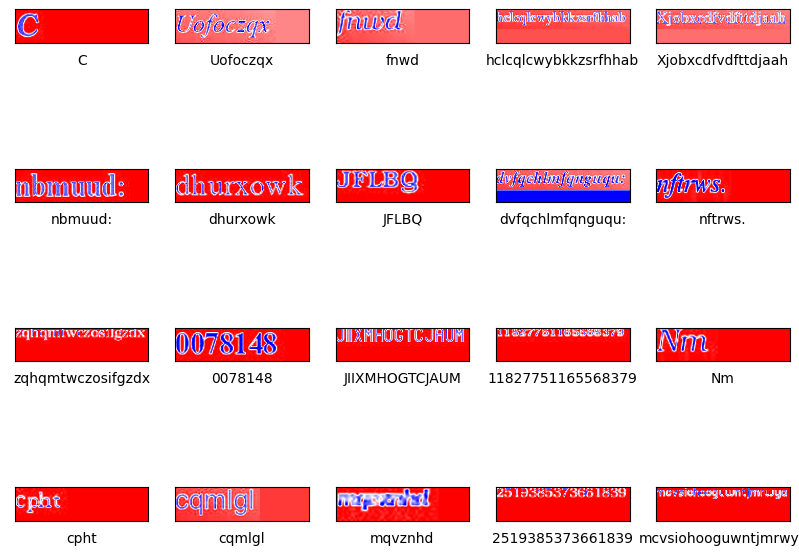

In [7]:
plot_images_sample(training_img, orig_txt)

In [8]:
# annot=open('/kaggle/input/characters-and-digits-for-classification/annotation.txt','r').readlines()
# imagenames=[]
# txts=[]

# for cnt in annot:
#     filename,txt=cnt.split(',')[0],cnt.split(',')[1].split('\n')[0]
#     imagenames.append(filename)
#     txts.append(txt)
    
# c = list(zip(imagenames, txts))

# imagenames, txts = zip(*c)
# img = cv2.imread('/kaggle/input/characters-and-digits-for-classification/images/images/'+imagenames[],0) 
# plt.imshow(img)
# plt.show()

In [9]:
#pad each output label to maximum text length
 
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [10]:
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)


conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
model = Model(inputs, outputs)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [11]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model_ctc = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [12]:
model_ctc.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, metrics=['accuracy'], optimizer = 'adam')
 
filepath="/kaggle/working/weights/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
model_ctc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 64)  640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 64, 128)  73856       ['max_pooling2d[0][0]']    

In [13]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [19]:
batch_size = 256
epochs = 15
history = model_ctc.fit(x=[training_img, train_padded_txt, train_input_length, 
             train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, 
             validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], 
                             [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)
     

Epoch 1/15
253/253 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9647
Epoch 1: val_loss did not improve from 0.57118
253/253 [==============================] - 105s 381ms/step - loss: 0.1039 - accuracy: 0.9647 - val_loss: 0.5731 - val_accuracy: 0.9074
Epoch 2/15
253/253 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9713
Epoch 2: val_loss did not improve from 0.57118
253/253 [==============================] - 92s 364ms/step - loss: 0.0808 - accuracy: 0.9713 - val_loss: 0.6205 - val_accuracy: 0.9028
Epoch 3/15
253/253 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9702
Epoch 3: val_loss did not improve from 0.57118
253/253 [==============================] - 92s 364ms/step - loss: 0.0861 - accuracy: 0.9702 - val_loss: 0.6076 - val_accuracy: 0.9053
Epoch 4/15
253/253 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9712
Epoch 4: val_loss did not improve from 0.57118
253/253 [================

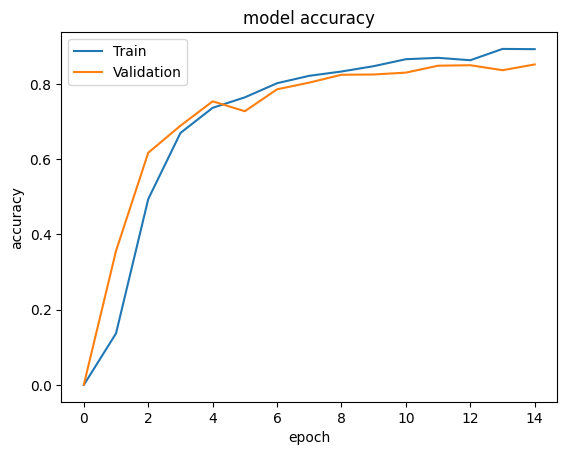

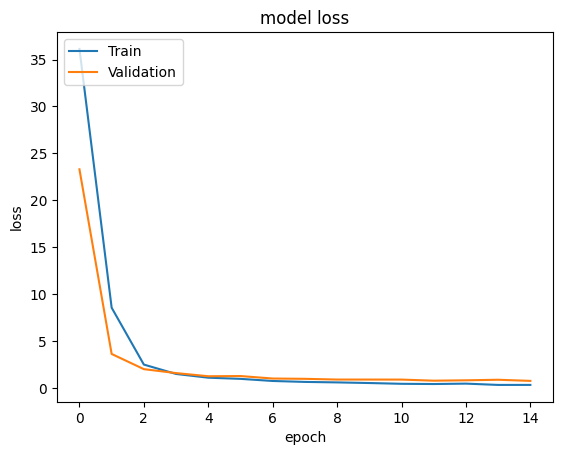

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# load the saved best model weights
model.load_weights('/kaggle/working/weights/best_model.hdf5')
 
# predict outputs on validation images
prediction = model.predict(valid_img[10:20])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 10
for x in out:
    print("original_text  =", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

1/1 [==============================] - 0s 32ms/step
original_text  = 786418887801
predicted text = 786418887801

original_text  = ulpohr
predicted text = ulpohr

original_text  = gjlpkopus
predicted text = gjlpkopus

original_text  = 8715686
predicted text = 8715686

original_text  = XQENCZNFQR
predicted text = XQENCZNFQR

original_text  = yempcdxtsduuxblywa
predicted text = yempcdxtsduuxblywa

original_text  = uihjqvekfmqkocscwb
predicted text = uihjqvskfmqkocscwb.

original_text  = fyzlebdamborjfvzten?
predicted text = fyzlebdamborjfvzten?

original_text  = Rdpsbfe
predicted text = Rdpsbfe

original_text  = REDCE
predicted text = REDCE

